In [1]:
%cd drive/My\ Drive/Projects/Hospitalization_Risk_COVID19/data/

/content/drive/My Drive/Projects/Hospitalization_Risk_COVID19/data


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import sklearn
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('200918COVID19MEXICO.csv', encoding='unicode_escape')

In [4]:
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-09-18,11e6c9,2,9,9,2,30,9,10,1,2020-06-22,2020-06-22,9999-99-99,97,2,39,1,97,2,2,2,2,2,2,2,2,2,2,2,1,1,99,MÃ©xico,99,97
1,2020-09-18,0f6da0,1,4,23,2,29,23,5,1,2020-04-22,2020-04-20,9999-99-99,97,2,26,1,97,2,2,2,2,2,2,2,2,1,2,2,1,1,99,MÃ©xico,99,97
2,2020-09-18,172af6,2,4,9,1,9,9,7,2,2020-04-20,2020-04-18,9999-99-99,2,2,63,1,2,2,2,2,2,2,2,2,2,1,2,2,99,1,99,MÃ©xico,99,2
3,2020-09-18,03fa11,1,4,23,2,27,23,5,2,2020-04-18,2020-04-14,9999-99-99,2,1,70,1,97,2,2,2,2,2,2,2,2,2,2,2,99,1,99,MÃ©xico,99,2
4,2020-09-18,08c7aa,1,12,9,2,15,9,17,2,2020-04-21,2020-04-15,9999-99-99,2,1,45,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,99,MÃ©xico,99,2


### Preprocessing

In [5]:
## Filter by positive cases
df = df[df['RESULTADO'] == 1]

In [6]:
 ## Drop unnecesary columns
 drop_cols = ['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'SECTOR', 'ENTIDAD_UM', 'INTUBADO', 'NEUMONIA', 'UCI',
              'SECTOR', 'ORIGEN', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'NACIONALIDAD',
              'HABLA_LENGUA_INDIG', 'OTRO_CASO', 'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 
              'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'EMBARAZO', 'RESULTADO']
df = df.drop(drop_cols, axis = 1)

In [7]:
## Replace '98's (nulls) for '0's.
## Except in the 'EDAD' column that corresponds to the age.
cols = list(df.columns)
cols.remove('EDAD')
for col in cols:
    df[col] = df[col].replace(98, 0)

In [8]:
# Target: 'TIPO_PACIENTE'
# Replace '1' for '0' (ambulatory)
# Replace '2' for '1' (hospitalized)
df['TIPO_PACIENTE'] = df['TIPO_PACIENTE'].replace(1, 0)
df['TIPO_PACIENTE'] = df['TIPO_PACIENTE'].replace(2, 1)

In [9]:
print('Total Cases: {:,}'.format(len(df)))
print('Hospitalization cases: {:,}'.format(sum(df['TIPO_PACIENTE'])))
print('Hospitalization ratio: {:.2f}%'.format(100*sum(df['TIPO_PACIENTE'])/len(df)))
df.head()

Total Cases: 688,954
Hospitalization cases: 168,356
Hospitalization ratio: 24.44%


,SEXO,TIPO_PACIENTE,EDAD,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO
0,2,0,39,2,2,2,2,2,2,2,2,2,2
1,2,0,26,2,2,2,2,2,2,2,1,2,2
2,1,1,63,2,2,2,2,2,2,2,1,2,2
3,2,1,70,2,2,2,2,2,2,2,2,2,2
4,2,1,45,2,2,2,2,2,2,2,2,2,2


In [10]:
## Setting correct dtype for categorical columns.
categorical_cols = ['SEXO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
                    'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
                    'RENAL_CRONICA', 'TABAQUISMO']
df = df.astype(dict(zip(categorical_cols, ['category']*len(categorical_cols))))
print(df.dtypes)

SEXO              category
TIPO_PACIENTE        int64
EDAD                 int64
DIABETES          category
EPOC              category
ASMA              category
INMUSUPR          category
HIPERTENSION      category
OTRA_COM          category
CARDIOVASCULAR    category
OBESIDAD          category
RENAL_CRONICA     category
TABAQUISMO        category
dtype: object


In [11]:
## One Hot Encoding.
## Could ommit this step without problem.
df_ohe = pd.get_dummies(df)

In [12]:
df_ohe.head()

,TIPO_PACIENTE,EDAD,SEXO_1,SEXO_2,DIABETES_0,DIABETES_1,DIABETES_2,EPOC_0,EPOC_1,EPOC_2,ASMA_0,ASMA_1,ASMA_2,INMUSUPR_0,INMUSUPR_1,INMUSUPR_2,HIPERTENSION_0,HIPERTENSION_1,HIPERTENSION_2,OTRA_COM_0,OTRA_COM_1,OTRA_COM_2,CARDIOVASCULAR_0,CARDIOVASCULAR_1,CARDIOVASCULAR_2,OBESIDAD_0,OBESIDAD_1,OBESIDAD_2,RENAL_CRONICA_0,RENAL_CRONICA_1,RENAL_CRONICA_2,TABAQUISMO_0,TABAQUISMO_1,TABAQUISMO_2
0,0,39,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
1,0,26,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1
2,1,63,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1
3,1,70,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
4,1,45,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1


In [13]:
## split the data
## test aprox with 30,000 examples
y = df_ohe['TIPO_PACIENTE'].copy()
X = df_ohe.drop(['TIPO_PACIENTE'], axis = 1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04354, random_state = 21, stratify = y)
print('Number of test examples:', len(y_test))

Number of test examples: 29998


### Training Models

* Logistic Regression (lr)

* Desicion Tree Classifier (dtc)

* Boosted Random Forest (brf)

* Gaussian Naives Bayes (gnb)

* XGBoost (xgb)

In [14]:
auc_all = []
recall_all = []
precision_all = []
f1_all = []
bal_acc_all = []
acc_all = []

In [15]:
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score as roc_auc

def evaluate_model(clf, sets):
  """Helper function to evaluate a model.

  Params:
    clf: trained model.
    sets: tuple of sets (X_train, X_test, y_train, y_test).

  Returns:
    train_metrics, test_metrics (tuples).
    test_metrics = (auc, recall, precision, f1, bal_acc, acc)
    
  """
  X_train, X_test, y_train, y_test = sets

  # Plot Confusion Matrix
  plot_confusion_matrix(clf,
                        X_test,
                        y_test,
                        values_format=',d',
                        display_labels=['Ambulante', 'Hospitalizado'])

  # Training set metrics
  tpreds = np.array(clf.predict(X_train))
  tauc = roc_auc(y_train, tpreds)
  trecall = rs(y_train, tpreds)
  tprecision = ps(y_train, tpreds)
  tf1 = fs(y_train, tpreds)
  tbal_acc = bas(y_train, tpreds)
  tacc = clf.score(X_train, y_train)
  print("**Evaluation Metrics for Train Set**")
  print("ROC Area Under the Curve:", tauc)
  print("Recall:", trecall)
  print("Precision:", tprecision)
  print("F1 Score:",tf1)
  print("Balanced Accuracy:", tbal_acc)
  print("Accuracy:", tacc)

  train_metrics = (tauc, trecall, tprecision, tf1, tbal_acc, tacc)

  # Test set metrics
  preds = np.array(clf.predict(X_test))
  auc = roc_auc(y_test, preds)
  recall = rs(y_test, preds)
  precision = ps(y_test, preds)
  f1 = fs(y_test, preds)
  bal_acc = bas(y_test, preds)
  acc = clf.score(X_test, y_test)
  print("\n**Evaluation Metrics for Test Set**")
  print("ROC Area Under the Curve:", auc)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1 Score:",f1)
  print("Balanced Accuracy:", bal_acc)
  print("Accuracy:", acc)

  test_metrics = (auc, recall, precision, f1, bal_acc, acc)

  return train_metrics, test_metrics

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**Evaluation Metrics for Train Set**
ROC Area Under the Curve: 0.6394786073330335
Recall: 0.34306261100691815
Precision: 0.6337853651820747
F1 Score: 0.44516253807597467
Balanced Accuracy: 0.6394786073330335
Accuracy: 0.7910270184959238

**Evaluation Metrics for Test Set**
ROC Area Under the Curve: 0.6401232777977188
Recall: 0.3431105047748977
Precision: 0.6383248730964467
F1 Score: 0.44631765749778174
Balanced Accuracy: 0.6401232777977188
Accuracy: 0.7919861324088272


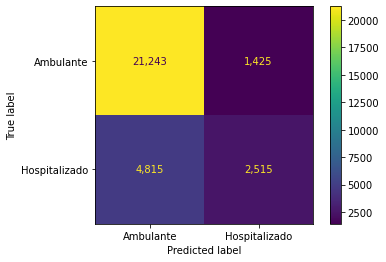

In [16]:
## Logistic Regression (lr)
from sklearn.linear_model import LogisticRegression as lr
clf_lr = lr(solver='sag')
clf_lr.fit(X_train, y_train)
train_metrics, test_metrics = evaluate_model(clf_lr, (X_train, X_test, y_train, y_test))

In [17]:
auc, recall, precision, f1, bal_acc, acc = test_metrics
auc_all.append(auc)
recall_all.append(recall_all)
precision_all.append(precision)
f1_all.append(f1)
bal_acc_all.append(bal_acc)
acc_all.append(acc)

**Evaluation Metrics for Train Set**
ROC Area Under the Curve: 0.6366585006205496
Recall: 0.34956466657558405
Precision: 0.5971990875815607
F1 Score: 0.4409963922109362
Balanced Accuracy: 0.6366585006205496
Accuracy: 0.7834407760153941

**Evaluation Metrics for Test Set**
ROC Area Under the Curve: 0.6381902621409077
Recall: 0.3510231923601637
Precision: 0.603282532239156
F1 Score: 0.44381198792583015
Balanced Accuracy: 0.6381902621409077
Accuracy: 0.7850190012667512


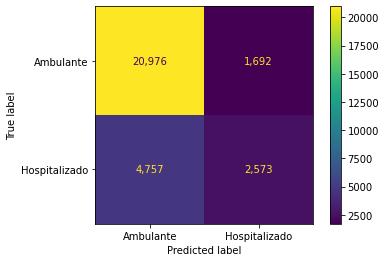

In [18]:
## Desicion Tree Classifier (dtc)
from sklearn.tree import DecisionTreeClassifier as dtc

clf_dtc = dtc(max_depth=2)
clf_dtc.fit(X_train, y_train)
train_metrics, test_metrics = evaluate_model(clf_dtc, (X_train, X_test, y_train, y_test))

In [19]:
auc, recall, precision, f1, bal_acc, acc = test_metrics
auc_all.append(auc)
recall_all.append(recall_all)
precision_all.append(precision)
f1_all.append(f1)
bal_acc_all.append(bal_acc)
acc_all.append(acc)

In [20]:
# Scale the ages because BRF and SVM take a long time to train.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

sc = preprocessing.StandardScaler()
sc.fit(X['EDAD'].to_numpy().reshape(X['EDAD'].shape[0], 1))

X_train_scaled['EDAD'] = sc.transform(X_train['EDAD'].to_numpy().reshape(X_train['EDAD'].shape[0], 1)).flatten()
X_test_scaled['EDAD'] = sc.transform(X_test['EDAD'].to_numpy().reshape(X_test['EDAD'].shape[0], 1)).flatten()

**Evaluation Metrics for Train Set**
ROC Area Under the Curve: 0.5182950314579332
Recall: 0.04142809235775589
Precision: 0.7346916299559472
F1 Score: 0.07843344737986901
Balanced Accuracy: 0.5182950314579332
Accuracy: 0.7621024772518954

**Evaluation Metrics for Test Set**
ROC Area Under the Curve: 0.5187637626323722
Recall: 0.04229195088676671
Precision: 0.7416267942583732
F1 Score: 0.08002065049044914
Balanced Accuracy: 0.5187637626323722
Accuracy: 0.7623841589439296


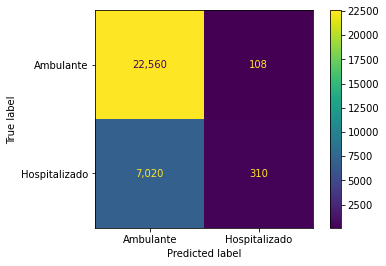

In [21]:
## Boosted Random Forest (brf)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                            criterion='gini', max_depth=2, max_features='auto',
                            max_leaf_nodes=None, max_samples=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=2, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_jobs=None, oob_score=False, random_state=None,
                            verbose=0, warm_start=False)
clf_brf = AdaBoostClassifier(rf,50,0.01,'SAMME.R',10)
clf_brf.fit(X_train_scaled, y_train)
train_metrics, test_metrics = evaluate_model(clf_brf, (X_train_scaled, X_test_scaled, y_train, y_test))

In [22]:
auc, recall, precision, f1, bal_acc, acc = test_metrics
auc_all.append(auc)
recall_all.append(recall_all)
precision_all.append(precision)
f1_all.append(f1)
bal_acc_all.append(bal_acc)
acc_all.append(acc)

**Evaluation Metrics for Train Set**
ROC Area Under the Curve: 0.5987943091740234
Recall: 0.2750673804230373
Precision: 0.5344748527850178
F1 Score: 0.3632092104076295
Balanced Accuracy: 0.5987943091740234
Accuracy: 0.764305962765344

**Evaluation Metrics for Test Set**
ROC Area Under the Curve: 0.6023707537306409
Recall: 0.28035470668485674
Precision: 0.5452374635181746
F1 Score: 0.37030363095774393
Balanced Accuracy: 0.6023707537306409
Accuracy: 0.7670178011867458


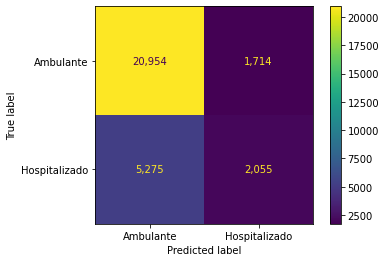

In [23]:
# Gaussian Naives Bayes (gnb)
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
train_metrics, test_metrics = evaluate_model(clf_gnb, (X_train, X_test, y_train, y_test))

In [24]:
auc, recall, precision, f1, bal_acc, acc = test_metrics
auc_all.append(auc)
recall_all.append(recall_all)
precision_all.append(precision)
f1_all.append(f1)
bal_acc_all.append(bal_acc)
acc_all.append(acc)

**Evaluation Metrics for Train Set**
ROC Area Under the Curve: 0.6588683368139789
Recall: 0.3950728453790071
Precision: 0.6229326805385557
F1 Score: 0.48350186774893494
Balanced Accuracy: 0.6588683368139789
Accuracy: 0.7937388839315523

**Evaluation Metrics for Test Set**
ROC Area Under the Curve: 0.6560325738803743
Recall: 0.38922237380627556
Precision: 0.6199478487614081
F1 Score: 0.4782098558498156
Balanced Accuracy: 0.6560325738803744
Accuracy: 0.7924528301886793


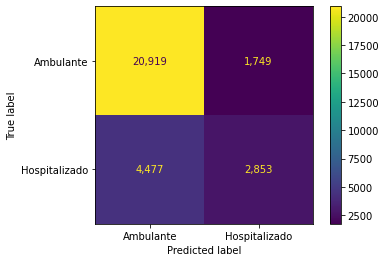

In [25]:
## XGBoost (xgb)
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=False,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])
train_metrics, test_metrics = evaluate_model(clf_xgb, (X_train, X_test, y_train, y_test))

In [26]:
auc, recall, precision, f1, bal_acc, acc = test_metrics
auc_all.append(auc)
recall_all.append(recall_all)
precision_all.append(precision)
f1_all.append(f1)
bal_acc_all.append(bal_acc)
acc_all.append(acc)

In [27]:
import matplotlib.pyplot as plt

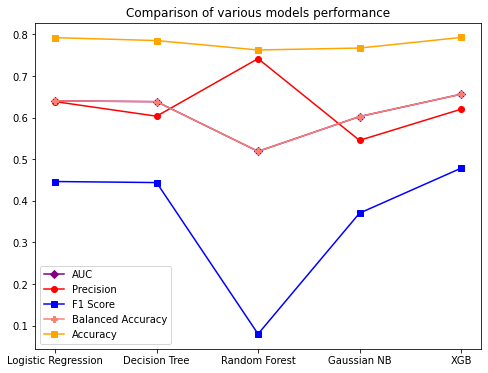

In [38]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gaussian NB', 'XGB']

fig = plt.figure(figsize=(8,6))

# plt.plot(models, recall_all, color='green', marker='o')
plt.plot(models, auc_all, color='purple', marker='D')
plt.plot(models, precision_all, color='red', marker='o')
plt.plot(models, f1_all, color='blue', marker='s')
plt.plot(models, bal_acc_all, color='salmon', marker='P')
plt.plot(models, acc_all, color='orange', marker='s')
plt.legend(['AUC', 'Precision', 'F1 Score', 'Balanced Accuracy', 'Accuracy'])
plt.title('Comparison of various models performance')

plt.show(fig)

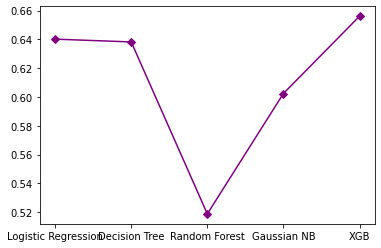

In [39]:
plt.plot(models, auc_all, color='purple', marker='D')